## Cancer Stem Cell Model-- Tumor simulation
Agent model based on 

### CSC neutral model

In [208]:
import pandas as pd
import numpy as np
import random
import copy
import baltic as bt
#create classes
class Cell:
    def __init__(self):
        self.parent = None #cell it was derived from
        self.children = [] #set of daughter cells
        self.locx = None #x location in lattice
        self.locy = None #y location in lattice
        self.birthdate = None
        self.deathdate = None
        self.pmax = 10 #proliferation potential
        self.cellnum = None #unique cell number to identify
        self.alpha = 0.01 #probability of sponaneous death
        self.mutation_rate = 0.1 #probability of mutation per cell division
        self.motility = None #probability of migration per day
        self.proliferation_rate = 1 #average cell divisions per day
        self.clone = None
        self.mutations = []
        self.ps = 0
        self.curnode = None
        self.new_mut = False

class StemCell(Cell): #define stem cell class
    def __init__(self):
        Cell.__init__(self)
        self.pmax = float('inf') #infinite proliferation potential
        self.alpha = 0 #immortal
        self.ps = 0 #probability of symmetric division

# class Clone(): #define clone class
#     def __init__(self):
#         self.parent = None
#         self.children = []
#         self.birthdate = None
#         self.deathdate = None
#         self.color = None
#         self.clonenum = None
#         self.mutations = []
#         self.alive_cells = []
#         self.node = None
# class Mutation(): #definate mutation class
#     def __init__(self):
#         self.cells = []
#         self.alive_cells = []
#         self.mutnum = 'None'
        
#create lattice array
N = 10000 # starting demensions of lattice
lattice = np.empty( (N,N), dtype=object)

#parameters
proliferation_rate_CC = 2
proliferation_rate_CSC = 1
pmax_CC = 10
migration_potential = 15
alpha_CC = 0.05
cur_cellnum = 1
cur_mutnum = 0
cur_clonenum = 1
cur_index = 1
mutation_rate = 0.1

tree = bt.tree()
root = bt.node()
root.length=0 ## branch length,
root.height=0 ## height, set by traversing the tree, which adds up branch lengths along the way
root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
root.index='root' ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
root.x=0## X and Y coordinates of this node, once drawTree() is called
root.alive_cells = []
tree.Objects.append(root)
tree.nodes.append(root)
tree.root = root
root.clone = 'o'

alive_cells = []
cells = []
mutations = []
clones = ['a','b','c','d']

i = int(N/2) #to place founder cell in center of lattic
modi = [0,0,1,1]
modj = [0,1,0,1]
for x in range(4):
    Fcell = StemCell() #initiate founder cell
    Fcell.locx = i+modi[x] #x location in lattice
    Fcell.locy = i+modj[x] #y location in lattice
    Fcell.birthdate = 0
    Fcell.cellnum = 0  #unique cell number to identify
    Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
    Fcell.motility = migration_potential #probability of migration per day
    Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per da
    Fcell.ps = 0.05
    Fcell.clone = clones[x]
    Fcell.curnode = root
    cells.append(Fcell)
    alive_cells.append(Fcell)
    Fcell.curnode.alive_cells.append(Fcell)

#initial founder clone object
# Fclone = Clone()
# Fclone.clone_num = 0
# Fclone.birthdate = 0
# Fcell.clone = Fclone
# Fclone.alive_cells.append(Fcell)
#Fclone.node = root

#initiate desired tracking system
#simpsons_diversity = [] #list to keep track of diversity at each time step
#clones = [] #list to contain each clone in population
#clones.append(Fclone) #add founding clone to list



#time parameters
dt = 1/float(24) # time is equilavent to 1/24 of a day or 1 hour
time = 0 #initialize time to 0
stop_time =20 #stop simulation after this many days


def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
    free_cells = []
    change = [1,-1]
    for c in change:
        checki = lattice[i+c,j]
        if checki == None:
            free_cells.append([i+c,j])
        checkj = lattice[i, j+c]
        if checkj == None:
            free_cells.append([i,j+c])
        for h in change:
            checkd = lattice[i+h,j+c]
            if checkd == None:
                free_cells.append([i+h,j+c])
    return free_cells


while time < stop_time:
    time += dt
    cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
    for cell in cell_stack:
        alive = True
        r = random.uniform(0, 1)
        pd = cell.proliferation_rate * dt #probability of proliferation in time dt
        free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
        if r < pd: # Does cell attempt to divide? 
            r = random.uniform(0,1)
            pdie = cell.alpha * pd #probability of spontaneously dying
            if r < pdie:
                alive = False
            elif len(free_cells) > 0: #is there any space to divide?
                if cell.pmax > 0: #is cell proliferation capacity exhausted?
                    r = random.uniform(0,1)
                    if r <= cell.ps: #does cell divide asymmetrically?
                        new_cell = Cell()
                        new_cell.mutation_rate = cell.mutation_rate#probability of mutation per cell division
                        new_cell.motility = cell.motility#probability of migration per day
                        new_cell.proliferation_rate = cell.proliferation_rate #average cell divisions per day
                        new_cell.clone = cell.clone
                        #new_cell.mutations = cell.mutations
                        new_cell.alpha = cell.alpha + 0.01
                    else:
                        new_cell = copy.deepcopy(cell)
                        new_cell.new_mut = False
                        #new_cell = copy.copy(cell)
                        
                    new_cell.parent = cell
                    newloc = random.choice(free_cells)
                    new_cell.locx = newloc[0] #x location in lattice
                    new_cell.locy = newloc[1] #y location in lattice
                    new_cell.birthdate = time
                    new_cell.cellnum = cur_cellnum #unique cell number to identify
                    cur_cellnum += 1
                    new_cell.children = []
                    new_cell.mutations = cell.mutations
                    new_cell.curnode = cell.curnode
                    new_cell.clone = cell.clone
                    renewed_cell = copy.deepcopy(cell)
                    renewed_cell.parent = cell
                    renewed_cell.locx = cell.locx
                    renewed_cell.locy = cell.locy
                    renewed_cell.birthdate = time
                    renewed_cell.cellnum = cur_cellnum
                    cur_cellnum += 1
                    renewed_cell.children = []
                    renewed_cell.new_mut = False
                    renewed_cell.curnode = cell.curnode
                    
                    
                    
                    
                    

                    r = random.uniform(0,1)
                    if r < cell.mutation_rate: #does cell gain a mutation?
                        #new_mut = Mutation()
                        #new_mut.mutnum = cur_mutnum
                        new_mut = cur_mutnum
                        cur_mutnum +=1
                        new_cell.mutations.append(new_mut)
                        new_cell.new_mut = True
#                         new_clone = Clone() #new mutation defines new clone group
#                         new_clone.parent = cell.clone
#                         new_clone.birthdate = time
#                         new_clone.clonenum = cur_clonenum
#                         cur_clonenum += 1
#                         new_clone.parent.children.append(new_clone) 
#                         new_clone.children.append(new_cell)
#                         new_clone.alive_cells.append(new_cell)
#                         new_cell.clone= new_clone
#                         clones.append(new_clone)
                        mutations.append(new_mut)
                        new_node = bt.node()
                        new_node.length= time - cell.curnode.x ## branch length,
                        new_node.height = time
                        new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                        new_node.parent=cell.curnode ## reference to parent node of the node
                        new_node.parent.children.append(new_node)
                        new_node.index=cur_index ## index of the character designating this object
                        cur_index += 1
                        new_node.locx = cell.locx
                        new_node.locy = cell.locy
                        new_node.alive_cells = []
                        new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
                        new_cell.curnode = new_node
                        new_node.clone = cell.clone
                        renewed_cell.curnode = new_node
                        tree.Objects.append(new_node)
                        tree.nodes.append(new_node)
                        cell.pmax -= 1


#                     else:
#                         cell.clone.alive_cells.append(new_cell)
                        
#                     for mut in new_cell.mutations:
#                         mut.alive_cells.append(new_cell)
#                         mut.cells.append(new_cell)
                        
                    new_cell.curnode.alive_cells.append(new_cell)
                    renewed_cell.curnode.alive_cells.append(renewed_cell)
                    cell.curnode.alive_cells.remove(cell)
                    cell.children.append(renewed_cell)
                    cell.children.append(new_cell)
                    alive_cells.append(renewed_cell)
                    alive_cells.append(new_cell)
                    alive_cells.remove(cell)
                    cell.deathdate = time
                    lattice[new_cell.locx,new_cell.locy] = new_cell
                    lattice[renewed_cell.locx,renewed_cell.locy] = renewed_cell
                    cells.append(renewed_cell)
                    cells.append(new_cell)
                    new_cell.pmax -= 1 
                    renewed_cell.pmax -= 1  
                else:
                    alive = False
            elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
                if len(free_cells) > 0:
                    newloc = random.choose(free_cells)
                    lattice[cell.locx,cell.locy] = 'None'
                    cell.locx = newloc[0]
                    cell.locy = newloc[1]
                    lattice[cell.locx,cell.locy] = cell
        if alive == False:
            alive_cells.remove(cell)
            cell.deathdate = time
            cell.curnode.alive_cells.remove(cell)
            if len(cell.curnode.alive_cells) == 0:
                
#             cell.clone.alive_cells.remove(cell)
#             if len(cell.clone.alive_cells) < 1:
#                 cell.clone.deathdate = time
#             if len(cell.mutations)>0:
#                 for mut in cell.mutations:
#                     mut.alive_cells.remove(cell)
#                 if len(mut.alive_cells) < 1:
#                     mutations.remove(mut)
            
                new_leaf = bt.leaf()
                new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
                cur_index += 1
                new_leaf.numName = new_leaf.index
                new_leaf.length=time - cell.curnode.x ## branch length
                new_leaf.absoluteTime=time ## position of tip in absolute time
                new_leaf.parent=cell.curnode ## parent
                new_leaf.parent.children.append(new_leaf)
                new_leaf.x=time## position of tip on x axis if the tip were to be plotted
                new_leaf.locx = cell.locx
                new_leaf.locy = cell.locy
                new_leaf.clone = cell.clone
                tree.Objects.append(new_leaf)
                tree.leaves.append(new_leaf)
                
usedparents = []
for cell in alive_cells:
    if not (cell.curnode in usedparents):
        new_leaf = bt.leaf()
        new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
        cur_index += 1
        new_leaf.length=stop_time - cell.curnode.x ## branch length
        new_leaf.height = stop_time
        new_leaf.absoluteTime=stop_time ## position of tip in absolute time
        new_leaf.parent=cell.curnode ## parent
        new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
        new_leaf.parent.children.append(new_leaf)
        new_leaf.numName = new_leaf.index
        new_leaf.clone = cell.clone
        tree.Objects.append(new_leaf)
        tree.leaves.append(new_leaf)
        curnode = new_leaf.parent
#         while curnode != None:
#             curnode.leaves.append(new_leaf)
#             curnode = curnode.parent
        usedparents.append(new_leaf.parent)
    

tree.treeHeight = stop_time

KeyboardInterrupt: 

In [209]:
usedparents = []
for cell in alive_cells:
    if not (cell.curnode in usedparents):
        new_leaf = bt.leaf()
        new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
        cur_index += 1
        new_leaf.length=time - cell.curnode.x ## branch length
        new_leaf.height = time
        new_leaf.absoluteTime=time ## position of tip in absolute time
        new_leaf.parent=cell.curnode ## parent
        new_leaf.x=time## position of tip on x axis if the tip were to be plotted
        new_leaf.parent.children.append(new_leaf)
        new_leaf.numName = new_leaf.index
        new_leaf.clone = cell.clone
        tree.Objects.append(new_leaf)
        tree.leaves.append(new_leaf)
        curnode = new_leaf.parent
#         while curnode != None:
#             curnode.leaves.append(new_leaf)
#             curnode = curnode.parent
        usedparents.append(new_leaf.parent)
    

tree.treeHeight = time

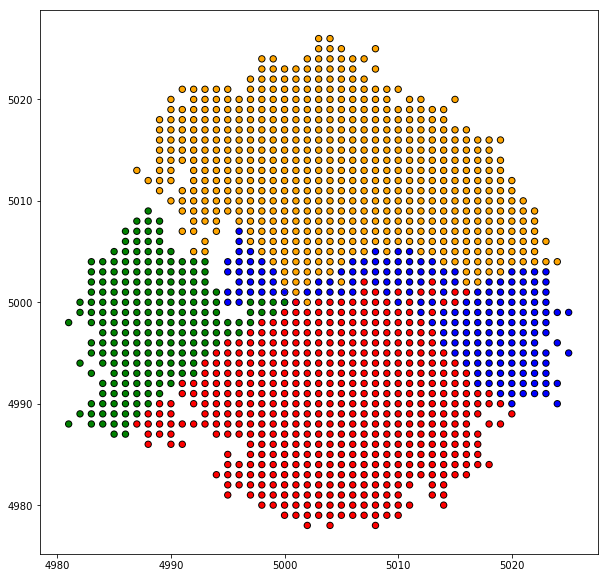

In [210]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w')
cmap=mpl.cm.viridis 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
for a in alive_cells:
    c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultation.png')
plt.show()

In [211]:
tree.traverse_tree()
tree.drawTree()

AttributeError: tree instance has no attribute 'yspan'

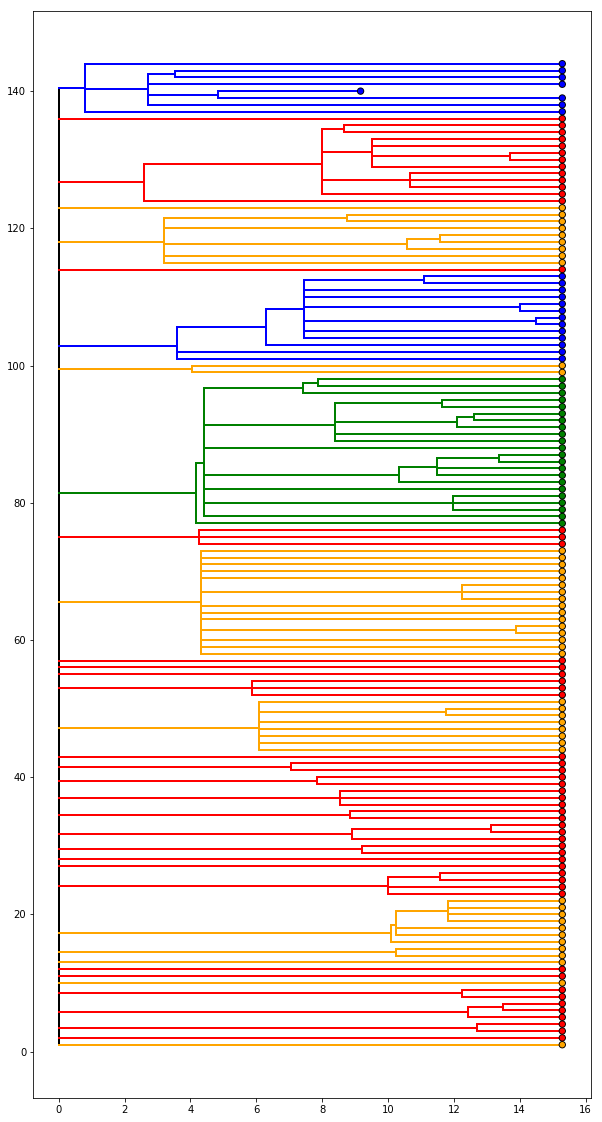

In [212]:
tree.traverse_tree()
tree.drawTree()
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":"k"}
    c = colordict[k.clone]

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,tree.yspan +5)


#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CSCsimultationtree.png')
plt.show()

## Clonal neutral model
Start w/ only clonal cells (no stem cells)

In [201]:
def cancer_sim(renew = True,deltat=1/float(24),CSC = True,stime = 10,proliferationCSC = 1, proliferationCC = 2, motility = 15, pmax = 10, mortality = 0.1,mutation = 0.1,selection = False):    
    import pandas as pd
    import numpy as np
    import random
    import copy
    import baltic as bt
    #create classes
    class Cell:
        def __init__(self):
            self.parent = None #cell it was derived from
            self.children = [] #set of daughter cells
            self.locx = None #x location in lattice
            self.locy = None #y location in lattice
            self.birthdate = None
            self.deathdate = None
            self.pmax = pmax #proliferation potential
            self.cellnum = None #unique cell number to identify
            self.alpha = 0.01 #probability of sponaneous death
            self.mutation_rate = mutation #probability of mutation per cell division
            self.motility = motility #probability of migration per day
            self.proliferation_rate = proliferationCC #average cell divisions per day
            self.clone = None
            self.mutations = []
            self.ps = 0
            self.curnode = None
            self.new_mut = False

    class StemCell(Cell): #define stem cell class
        def __init__(self):
            Cell.__init__(self)
            self.pmax = float('inf') #infinite proliferation potential
            self.alpha = 0 #immortal
            self.ps = 0 #probability of symmetric division
            self.proliferation_rate = proliferationCSC


    #create lattice array
    N = 10000 # starting demensions of lattice
    lattice = np.empty( (N,N), dtype=object)

    #parameters
    proliferation_rate_CC = proliferationCC
    proliferation_rate_CSC = proliferationCSC
    pmax_CC = pmax
    migration_potential = motility
    alpha_CC = mortality
    cur_cellnum = 1
    cur_mutnum = 0
    cur_clonenum = 1
    cur_index = 1
    mutation_rate = mutation
    time = 0

    tree = bt.tree()
    root = bt.node()
    root.length=0 ## branch length,
    root.height=0 ## height, set by traversing the tree, which adds up branch lengths along the way
    root.absoluteTime=0 ## branch end point in absolute time, once calibrations are done
    root.index='root' ## index of the character designating this object in the tree string, it's a unique identifier for every object in the tree
    root.x=0## X and Y coordinates of this node, once drawTree() is called
    root.alive_cells = []
    tree.Objects.append(root)
    tree.nodes.append(root)
    tree.root = root
    root.clone = 'o'

    alive_cells = []
    cells = []
    mutations = []
    clones = ['a','b','c','d']

    i = int(N/2) #to place founder cell in center of lattic
    modi = [0,0,1,1]
    modj = [0,1,0,1]
    if CSC == True:
        for x in range(4):
            Fcell = StemCell() #initiate founder cells, stem-cells
            Fcell.ps = 0.05
            Fcell.proliferation_rate = proliferation_rate_CSC #average cell divisions per day
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = 0  #unique cell number to identify
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
            Fcell.clone = clones[x]
            Fcell.curnode = root
            cells.append(Fcell)
            alive_cells.append(Fcell)
            Fcell.curnode.alive_cells.append(Fcell)
    else:
        for x in range(4):
            Fcell = Cell() #initiate founder cells, non-stem cells
            Fcell.proliferation_rate = proliferation_rate_CC
            Fcell.locx = i+modi[x] #x location in lattice
            Fcell.locy = i+modj[x] #y location in lattice
            Fcell.birthdate = 0
            Fcell.cellnum = 0  #unique cell number to identify
            Fcell.mutation_rate = mutation_rate #probability of mutation per cell division
            Fcell.motility = migration_potential #probability of migration per day
            Fcell.clone = clones[x]
            cells.append(Fcell)
            alive_cells.append(Fcell)
    for cell in alive_cells:
        new_node = bt.node()
        new_node.length= time - root.x ## branch length,
        new_node.height = time
        new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
        new_node.parent=root ## reference to parent node of the node
        root.children.append(new_node)
        new_node.index=cur_index ## index of the character designating this object
        cur_index += 1
        new_node.locx = cell.locx
        new_node.locy = cell.locy
        new_node.alive_cells = []
        new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
        cell.curnode = new_node
        new_node.clone = cell.clone
        new_node.alive_cells.append(cell)
        tree.Objects.append(new_node)
        tree.nodes.append(new_node)



    #time parameters
    dt = deltat # time is equilavent to 1/24 of a day or 1 hour
    stop_time =stime#stop simulation after this many days


    def adjacent_cell(lattice,i,j): #function to check if adjacent cells are empty
        free_cells = []
        change = [1,-1]
        for c in change:
            checki = lattice[i+c,j]
            if checki == None:
                free_cells.append([i+c,j])
            checkj = lattice[i, j+c]
            if checkj == None:
                free_cells.append([i,j+c])
            for h in change:
                checkd = lattice[i+h,j+c]
                if checkd == None:
                    free_cells.append([i+h,j+c])
        return free_cells

    print stop_time
    while time < stop_time:
        time += dt
        cell_stack = random.sample(alive_cells,len(alive_cells)) #random order of cells
        for cell in cell_stack:
            alive = True
            r = random.uniform(0, 1)
            pd = cell.proliferation_rate * dt #probability of proliferation in time dt
            free_cells = adjacent_cell(lattice,cell.locx,cell.locy)
            if r < pd: # Does cell attempt to divide? 
                r = random.uniform(0,1)
                pdie = cell.alpha * pd #probability of spontaneously dying
                if r < pdie:
                    alive = False
                elif len(free_cells) > 0: #is there any space to divide?
                    if cell.pmax > 0: #is cell proliferation capacity exhausted?
                        r = random.uniform(0,1)
                        if r <= cell.ps: #does cell divide asymmetrically?
                            new_cell = Cell()
                            new_cell.mutation_rate = cell.mutation_rate #probability of mutation per cell division
                            new_cell.motility = cell.motility#probability of migration per day
                            new_cell.proliferation_rate = proliferation_rate_CC #average cell divisions per day
                            new_cell.clone = cell.clone
                            #new_cell.mutations = cell.mutations
                            new_cell.alpha = cell.alpha + 0.01
                        else:
                            new_cell = copy.deepcopy(cell)
                            new_cell.new_mut = False
                            #new_cell = copy.copy(cell)

                        new_cell.parent = cell
                        newloc = random.choice(free_cells)
                        new_cell.locx = newloc[0] #x location in lattice
                        new_cell.locy = newloc[1] #y location in lattice
                        new_cell.birthdate = time
                        new_cell.cellnum = cur_cellnum #unique cell number to identify
                        cur_cellnum += 1
                        new_cell.children = []
                        new_cell.mutations = cell.mutations
                        new_cell.curnode = cell.curnode
                        new_cell.clone = cell.clone
                        if renew == True:
                            renewed_cell = copy.deepcopy(cell)
                            renewed_cell.parent = cell
                            renewed_cell.locx = cell.locx
                            renewed_cell.locy = cell.locy
                            renewed_cell.birthdate = time
                            renewed_cell.cellnum = cur_cellnum
                            cur_cellnum += 1
                            renewed_cell.children = []
                            renewed_cell.new_mut = False
                            renewed_cell.curnode = cell.curnode






                        r = random.uniform(0,1)
                        if r < cell.mutation_rate: #does cell gain a mutation?
                            #new_mut = Mutation()
                            #new_mut.mutnum = cur_mutnum
                            new_mut = cur_mutnum
                            cur_mutnum +=1
                            new_cell.mutations.append(new_mut)
                            new_cell.new_mut = True
                            mutations.append(new_mut)
                            new_node = bt.node()
                            new_node.length= time - cell.curnode.x ## branch length,
                            new_node.height = time
                            new_node.absoluteTime=time ## branch end point in absolute time, once calibrations are done
                            new_node.parent=cell.curnode ## reference to parent node of the node
                            new_node.parent.children.append(new_node)
                            new_node.index=cur_index ## index of the character designating this object
                            cur_index += 1
                            new_node.locx = cell.locx
                            new_node.locy = cell.locy
                            new_node.alive_cells = []
                            new_node.x=time ## X and Y coordinates of this node, once drawTree() is called
                            new_cell.curnode = new_node
                            new_node.clone = cell.clone
                            if renew == True:
                                renewed_cell.curnode = new_node
                            tree.Objects.append(new_node)
                            tree.nodes.append(new_node)
                            cell.pmax -= 1


    #                     else:
    #                         cell.clone.alive_cells.append(new_cell)

    #                     for mut in new_cell.mutations:
    #                         mut.alive_cells.append(new_cell)
    #                         mut.cells.append(new_cell)

                        new_cell.curnode.alive_cells.append(new_cell)
                        if renew == True:
                            renewed_cell.curnode.alive_cells.append(renewed_cell)
                            cell.curnode.alive_cells.remove(cell)
                            cell.children.append(renewed_cell)
                            alive_cells.append(renewed_cell)
                            alive_cells.remove(cell)
                            lattice[renewed_cell.locx,renewed_cell.locy] = renewed_cell
                            cells.append(renewed_cell)
                            cell.deathdate = time
                            renewed_cell.pmax -= 1  
                        cell.children.append(new_cell)
                        alive_cells.append(new_cell)
                        lattice[new_cell.locx,new_cell.locy] = new_cell
                        cells.append(new_cell)
                        new_cell.pmax -= 1 
                    else:
                        alive = False
                elif random.uniform(0, 1) < (cell.motility*dt): #if doesn't divide does it move (mutually exclusive)
                    if len(free_cells) > 0:
                        newloc = random.choose(free_cells)
                        lattice[cell.locx,cell.locy] = 'None'
                        cell.locx = newloc[0]
                        cell.locy = newloc[1]
                        lattice[cell.locx,cell.locy] = cell
            if alive == False:
                alive_cells.remove(cell)
                cell.deathdate = time
                cell.curnode.alive_cells.remove(cell)
                if len(cell.curnode.alive_cells) == 0:

                    new_leaf = bt.leaf()
                    new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
                    cur_index += 1
                    new_leaf.numName = new_leaf.index
                    new_leaf.length=time - cell.curnode.x ## branch length
                    new_leaf.absoluteTime=time ## position of tip in absolute time
                    new_leaf.parent=cell.curnode ## parent
                    new_leaf.parent.children.append(new_leaf)
                    new_leaf.x=time## position of tip on x axis if the tip were to be plotted
                    new_leaf.locx = cell.locx
                    new_leaf.locy = cell.locy
                    new_leaf.clone = cell.clone
                    tree.Objects.append(new_leaf)
                    tree.leaves.append(new_leaf)

    usedparents = []
    for cell in alive_cells:
        if not (cell.curnode in usedparents):
            new_leaf = bt.leaf()
            new_leaf.index=cur_index ## index of the character that defines this object, will be a unique ID for each object in the tree
            cur_index += 1
            new_leaf.length=stop_time - cell.curnode.x ## branch length
            new_leaf.height = stop_time
            new_leaf.absoluteTime=stop_time ## position of tip in absolute time
            new_leaf.parent=cell.curnode ## parent
            new_leaf.x=stop_time## position of tip on x axis if the tip were to be plotted
            new_leaf.parent.children.append(new_leaf)
            new_leaf.numName = new_leaf.index
            new_leaf.clone = cell.clone
            tree.Objects.append(new_leaf)
            tree.leaves.append(new_leaf)
            curnode = new_leaf.parent
    #         while curnode != None:
    #             curnode.leaves.append(new_leaf)
    #             curnode = curnode.parent
            usedparents.append(new_leaf.parent)


    tree.treeHeight = stop_time
    return cells, tree

In [224]:
alive_cells_CC,tree_CC = cancer_sim(stime = 5,proliferationCSC = 0.5,proliferationCC = 1,renew = True,CSC = False,pmax = 20)

5


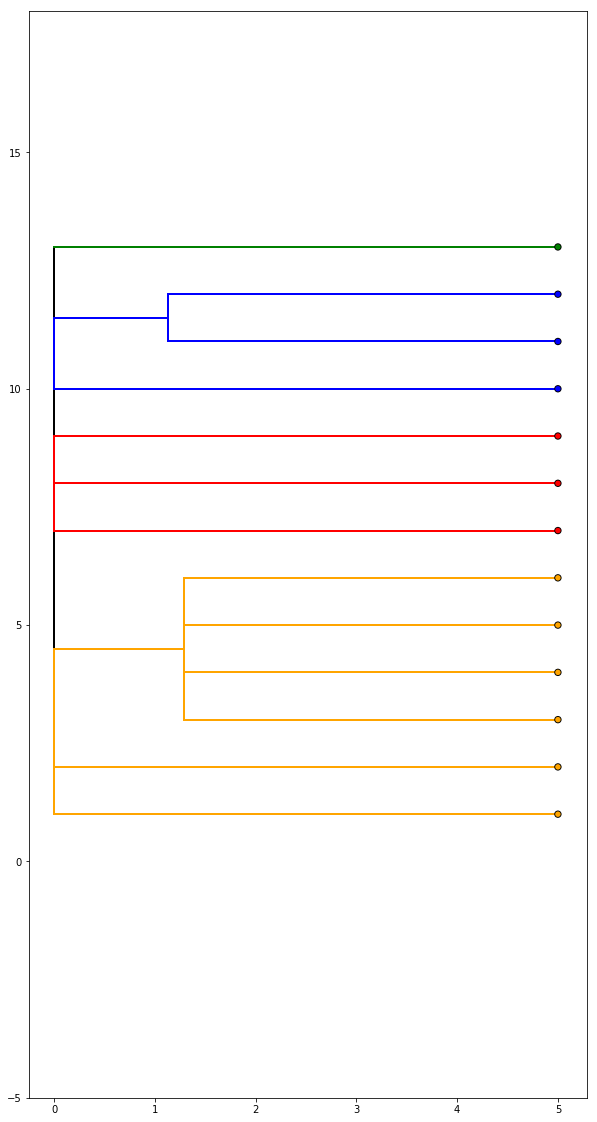

In [225]:
tree_CC.traverse_tree()
tree_CC.drawTree()
fig1,ax = plt.subplots(figsize=(10,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors

for k in tree_CC.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
#     x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    if k.parent != None:
        xp=k.parent.x ## get x position of current object's parent
    else:
        xp = None
#     xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp= x
    colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":"k"}
    c = colordict[k.clone]

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=30 ## tip size can be fixed
        #s=50-30*k.height/tree2.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
        
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)
    
       
ax.set_ylim(-5,tree_CC.ySpan+5)
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CCsimultationtree.png')
plt.show()

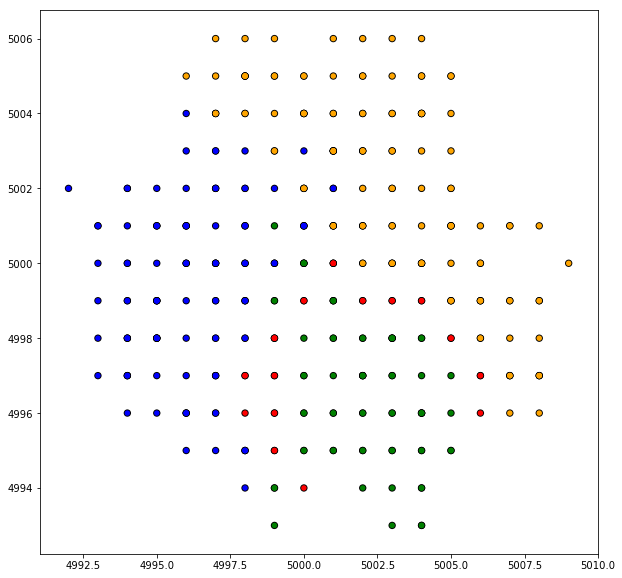

In [226]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
fig1,ax = plt.subplots(figsize=(10,10),facecolor='w') 
colordict = {"a":'green',"b":'blue',"c":"red","d":"orange","o":'k'}
for a in alive_cells_CC:
    c = colordict[a.clone]
#     cindx = [i for i in range(len(sortedclones)) if sortedclones[i] == a.clone]
#     color = np.linspace(0,1,len(clones))[cindx[0]]
#     c = cmap(color)
    branchWidth=2 ## default branch width
    x = a.locx
    y = a.locy
    s = 30
    ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
#han_list = []

#for key in colors2:
    #marker = mlines.Line2D(range(1), range(1), color = colors2[key], marker='o', markerfacecolor = colors2[key], label = key, markeredgecolor='k',markersize = 8)
    #han_list.append(marker)

#plt.legend(handles = han_list,markerfirst = True,title = 'Clone')
plt.savefig('figures/CCsimultation.png')
plt.show()

## w/ selection